In [193]:
import os
import time
import numpy as np
#from numpy.lib.stride_tricks import as_strided
import scipy
import scipy.signal
import xlrd
import pandas as pd
import sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import itertools
from itertools import combinations
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm
import subprocess
#print(os.getcwd())
from pack import peakutils#(Package from MIT la

In [4]:
def overlap_windows(data,overlap_rate,window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    return window_list

In [99]:
def compute_statistic_single(arr):
    mean_list = []
    range_list = []
    max_list = []
    min_list = []
    medium_list = []
    sum_list = []
    std_list = []
    mean_list.append(np.mean(arr))
    max_list.append(np.max(arr))
    min_list.append(np.min(arr))
    medium_list.append(np.median(arr))
    sum_list.append(np.sum(arr))
    std_list.append(np.std(arr))
    range_list.append(np.max(arr)-np.min(arr))
    return mean_list,max_list,min_list,medium_list,sum_list,std_list,range_list

In [80]:
def smooth(a,WSZ):#WSZ must be odd number
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((start,out0,stop))
#
def compute_IBI(BVP, framerate):    
    x = BVP-smooth(BVP,round(framerate+0.01)+1)
    x = np.array(x)
    locs = peakutils.indexes(x, thres=0.2, min_dist=50)#
    IBI = np.diff(locs)
    return locs,IBI
#
def compute_HRV(IBI):#,locs):
    epsilon = 0.007
    LF_band = [0.04, 0.15]# Low-frequency band
    HF_band = [0.15, 0.4]#High-frequency band (unit: hz)
    pp50_variable =0.05
    
    #LF
    freq,PERIODOGRAM = scipy.signal.periodogram(IBI)#,window = locs[1:len(locs)])
    index_1 = [i for i in range(len(freq)) if np.abs(freq[i]-LF_band[0])<epsilon]
    target_1 = np.min(index_1)-1
    index_2 = [i for i in range(len(freq)) if np.abs(freq[i]-LF_band[1])<epsilon]
    target_2 = np.min(index_2)
    LF=np.abs(np.sum(PERIODOGRAM[target_1:target_2]))
   
    #HF      
    index_3 = [i for i in range(len(freq)) if np.abs(freq[i]-HF_band[0])<epsilon]
    target_3 = np.min(index_3)-1
    index_4 = [i for i in range(len(freq)) if np.abs(freq[i]-HF_band[1])<epsilon]
    target_4 = np.min(index_4)
    HF=np.abs(np.sum(PERIODOGRAM[target_3:target_4]))         
    
    #Others
    LFHF=LF/HF
    SDPP=np.std(IBI)
    diff_IBI= np.diff(IBI)
    
    RMSSD=np.sqrt(np.mean(diff_IBI))
    b=[val for val in diff_IBI if val > pp50_variable]
    pPP50=len(b)/len(IBI)
    return LF,HF,LFHF,SDPP,RMSSD,pPP50

In [12]:
#load data
Res = pd.read_csv("F:\\UCL\\DT\\df_RES.csv")
BVP = pd.read_csv("F:\\UCL\\DT\\df_BVP.csv")
EDAL = pd.read_csv("F:\\UCL\\DT\\df_EDAL.csv")
EDAR = pd.read_csv("F:\\UCL\\DT\\df_EDAR.csv")
#Labels
labels2 = pd.read_csv("F:\\UCL\\DT\\labels2.csv")

In [197]:
labels2 = pd.read_excel("F:\\UCL\\DT\\labels2_enlarge.xlsx")
labels2.head()

,Labels
0,0
1,0
2,0
3,0
4,0


In [41]:
Res_data = Res.iloc[:,1:-1]
BVP_data = BVP.iloc[:,1:-1]
edal_data = EDAL.iloc[:,1:-1]
edar_data = EDAR.iloc[:,1:-1]

In [42]:
#Enlarge res data
Enlarge_res = []
for i in range(len(Res_data)):
    enlarge = overlap_windows(np.array(Res_data.iloc[i]),0.5,256*120)
    for j in range(len(enlarge)):
        Enlarge_res.append(enlarge[j])
Enlarge_res = pd.DataFrame(Enlarge_res)
Enlarge_res.head()

,0,1,2,3,4,5,6,7,8,9,...,30710,30711,30712,30713,30714,30715,30716,30717,30718,30719
0,22.829,22.828,22.827,22.826,22.824,22.823,22.822,22.820,22.819,22.818,...,22.466,22.466,22.466,22.465,22.465,22.464,22.465,22.465,22.465,22.465
1,24.396,24.389,24.383,24.376,24.369,24.362,24.356,24.349,24.342,24.335,...,24.368,24.364,24.361,24.358,24.355,24.351,24.348,24.344,24.341,24.338
2,22.465,22.465,22.465,22.466,22.466,22.465,22.465,22.465,22.465,22.466,...,25.121,25.115,25.110,25.104,25.099,25.093,25.087,25.081,25.075,25.068
3,20.057,20.065,20.075,20.084,20.093,20.102,20.112,20.122,20.131,20.140,...,22.231,22.226,22.221,22.215,22.210,22.204,22.200,22.195,22.190,22.185
4,22.180,22.173,22.167,22.160,22.154,22.148,22.142,22.136,22.131,22.125,...,21.763,21.761,21.758,21.756,21.754,21.752,21.750,21.747,21.745,21.743


In [105]:
#extract Res features
mean_res = []
max_res = []
min_res = []
medium_res = []
sum_res = []
std_res = []
range_res = []
for i in range(len(Enlarge_res)):
    mean_list,max_list,min_list,medium_list,sum_list,std_list,range_list = compute_statistic_single(Enlarge_res.iloc[i])
    mean_res.append(mean_list)
    max_res.append(max_list)
    min_res.append(min_list)
    medium_res.append(medium_list)
    sum_res.append(sum_list)
    std_res.append(std_list)
    range_res.append(range_list)

mean_res = pd.DataFrame(mean_res)
max_res = pd.DataFrame(max_res)
min_res = pd.DataFrame(min_res)
medium_res = pd.DataFrame(medium_res)
sum_res = pd.DataFrame(sum_res)
std_res = pd.DataFrame(std_res)
range_res = pd.DataFrame(range_res)
range_res.head()

,0
0,6.397
1,6.091
2,6.166
3,7.514
4,4.402


In [43]:
#Enlarge BVP data
Enlarge_bvp = []
for i in range(len(BVP_data)):
    enlarge = overlap_windows(np.array(BVP_data.iloc[i]),0.5,256*120)
    for j in range(len(enlarge)):
        Enlarge_bvp.append(enlarge[j])
Enlarge_bvp = pd.DataFrame(Enlarge_bvp)
Enlarge_bvp.head()

,0,1,2,3,4,5,6,7,8,9,...,30710,30711,30712,30713,30714,30715,30716,30717,30718,30719
0,30.699,30.660,30.622,30.585,30.550,30.517,30.486,30.456,30.429,30.404,...,37.235,37.167,37.098,37.027,36.954,36.880,36.805,36.728,36.650,36.570
1,29.148,29.137,29.128,29.120,29.112,29.104,29.094,29.084,29.072,29.057,...,47.020,47.212,47.362,47.473,47.548,47.590,47.601,47.584,47.543,47.477
2,36.489,36.406,36.323,36.238,36.153,36.068,35.981,35.894,35.806,35.718,...,37.333,37.293,37.247,37.196,37.140,37.080,37.016,36.948,36.877,36.804
3,32.056,32.017,31.978,31.939,31.901,31.863,31.826,31.789,31.753,31.718,...,43.806,43.675,43.536,43.389,43.234,43.073,42.904,42.730,42.551,42.367
4,31.976,31.928,31.881,31.836,31.791,31.747,31.704,31.660,31.617,31.572,...,31.947,31.882,31.820,31.762,31.708,31.656,31.607,31.560,31.516,31.472


In [118]:
#Compute bvp features
LF_list = []
HF_list = []
LFHF_list = []
SDPP_list = []
RMSSD_list = []
pPP50_list = []
#IBI
framerate = 256
IBI_list = []
locs_list = []
for i in range(len(Enlarge_bvp)):
    BVP = Enlarge_bvp.iloc[i]
    locs,IBI = compute_IBI(BVP,framerate)
    locs_list.append(locs)
    IBI_list.append(IBI) 
#HRV matrix
for i in range(len(IBI_list)):
    LF,HF,LFHF,SDPP,RMSSD,pPP50 = compute_HRV(IBI_list[i])
    LF_list.append(LF)
    HF_list.append(HF)
    LFHF_list.append(LFHF)
    SDPP_list.append(SDPP)
    RMSSD_list.append(RMSSD)
    pPP50_list.append(pPP50)
step = int(len(IBI_list)/len(Enlarge_bvp))
LF_list = [LF_list[i:i+step] for i in range(0,len(LF_list),step)]
HF_list = [HF_list[i:i+step] for i in range(0,len(HF_list),step)]
LFHF_list = [LFHF_list[i:i+step] for i in range(0,len(LFHF_list),step)]
SDPP_list = [SDPP_list[i:i+step] for i in range(0,len(SDPP_list),step)]
RMSSD_list= [RMSSD_list[i:i+step] for i in range(0,len(RMSSD_list),step)]
pPP50_list = [pPP50_list[i:i+step] for i in range(0,len(pPP50_list),step)]
LF_list = pd.DataFrame(LF_list)
HF_list = pd.DataFrame(HF_list)
LFHF_list = pd.DataFrame(LFHF_list) 
SDPP_list = pd.DataFrame(SDPP_list)  
pPP50_list = pd.DataFrame(pPP50_list)
RMSSD_list = pd.DataFrame(RMSSD_list)
pPP50_list.head()

F:\Anocanda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt


,0
0,0.502304
1,0.506849
2,0.502283
3,0.520000
4,0.532258


In [123]:
#Enlarge gsr data
Enlarge_edal = []
Enlarge_edar = []
#
for i in range(len(edal_data)):
    enlarge = overlap_windows(np.array(edal_data.iloc[i]),0.5,4*120)
    for j in range(len(enlarge)):
        Enlarge_edal.append(enlarge[j])
Enlarge_edal = pd.DataFrame(Enlarge_edal)

#
for i in range(len(edar_data)):
    enlarge = overlap_windows(np.array(edar_data.iloc[i]),0.5,4*120)
    for j in range(len(enlarge)):
        Enlarge_edar.append(enlarge[j])
Enlarge_edar = pd.DataFrame(Enlarge_edar)
Enlarge_edar.head()

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
0,8.783386,8.787228,8.792350,8.787228,8.785947,8.784667,8.784667,8.788508,8.779545,8.788508,...,9.141740,9.139179,9.121251,9.117410,9.118690,9.113567,9.111007,9.108445,9.094359,9.099482
1,8.873025,8.869184,8.875587,8.881989,8.879428,8.873025,8.870464,8.867903,8.858939,8.865342,...,9.233940,9.237782,9.230099,9.233940,9.235221,9.233940,9.231380,9.231380,9.231380,9.249307
2,9.090518,9.085396,9.086676,9.078993,9.068748,9.076431,9.073871,9.072590,9.067468,9.055943,...,9.338946,9.347910,9.361997,9.381205,9.387608,9.391449,9.410658,9.411938,9.414499,9.419621
3,11.121881,11.260181,11.416410,11.527819,11.729086,11.889155,12.004406,12.167688,12.202263,12.244522,...,13.995506,14.022398,14.042887,14.062096,14.091548,14.136368,14.126123,14.127404,14.138929,14.201676
4,12.784235,12.846983,12.898205,12.926377,12.916133,12.889241,12.867472,12.857227,12.838018,12.813688,...,14.102437,14.088351,14.072985,14.071704,14.099876,14.110121,14.147257,14.201040,14.288118,14.347024


In [157]:
#compute GSR features
import biosppy.signals
from biosppy.signals import eda
def feature_GSR(data):
    ts,filtered,onsets,peaks,amplitudes = biosppy.signals.eda.eda(data,sampling_rate = 16.0,show=False)
    #average SCR amplitude mean
    amplitude_mean = np.mean(np.array(amplitudes))
    #Number of SCR
    scr_number = len(amplitudes)
    #Mean skin conductance
    msc = np.mean(np.array(filtered))
    #mean rise time of SCR
    rt = []
    for i in range(len(onsets)):
        diff = peaks[i]-onsets[i]
        rt.append(diff)
    rtm = np.mean(np.array(rt)) 
    return amplitude_mean,scr_number,msc,rtm

In [168]:
amplitude_mean_llist = []
scr_llist = []
msc_llist = []
rtm_llist = []
for i in range(len(Enlarge_edal)):
    amplitude_mean,scr,msc,rtm = feature_GSR(np.array(Enlarge_edal.iloc[i]))
    amplitude_mean_llist.append(amplitude_mean)
    scr_llist.append(scr)
    msc_llist.append(msc)
    rtm_llist.append(rtm)  
msc_llist = pd.DataFrame(msc_llist)
rtm_llist = pd.DataFrame(rtm_llist)
scr_llist = pd.DataFrame(scr_llist)
amplitude_mean_llist = pd.DataFrame(amplitude_mean_llist)
GSR_data = pd.concat((msc_llist,rtm_llist,scr_llist,amplitude_mean_llist),axis=1,ignore_index=True)
GSR_data.head()
# #left
# amplitude_mean_rlist = []
# scr_rlist = []
# msc_rlist = []
# rtm_rlist = []
# for i in range(len(Enlarge_edar)):
#     amplitude_mean,scr,msc,rtm = feature_GSR(np.array(Enlarge_edar.iloc[i]))
#     amplitude_mean_rlist.append(amplitude_mean)
#     scr_rlist.append(scr)
#     msc_rlist.append(msc)
#     rtm_rlist.append(rtm)

,0,1,2,3
0,0.012864,8.733333,15,0.000031
1,0.013038,12.214286,14,0.000031
2,0.013354,12.642857,14,0.000027
3,0.015966,17.000000,3,0.000428
4,0.015711,10.307692,13,0.000093


In [170]:
#calculate landmarks feature
def cal_features(data):
    final_landfeature = None
    for i in range(np.shape(data)[1]):
        data_use = data.iloc[:,i]
        one_direction = []
        start = 0
        end = 3
        remain = len(data_use)
        while remain>=3:
            one_direction.append(np.mean(data_use[start:end]))
            start += 3
            end += 3
            remain -= 3
        filtered_data = scipy.signal.savgol_filter(np.array(one_direction),41,5)
        locs = peakutils.indexes(filtered_data, thres=0, min_dist=50)####改
        feature_list = []
        feature_list.append(np.mean(np.diff(locs)))#mean interval
        feature_list.append(np.mean(filtered_data[locs]))#mean magnitude
        feature_list.append(np.max(filtered_data[locs]))#max magnitude
        feature_list = pd.DataFrame(feature_list).T
        final_landfeature = pd.concat((final_landfeature,feature_list),axis=1,ignore_index = True)                                       
    return final_landfeature   

In [78]:
#enlarge facial data
b=1
for i in range(26):
    name = "*p"+str(i)+".csv"
    file_dir = "F:\\UCL\\DT\\processed"
    for filename in glob(os.path.join(file_dir, name)):
        data = pd.read_csv(filename,sep=",")
        data_use = data.copy()
        #name = filename[23:24]
        #
        read = data_use.iloc[0:30*120+1,:]
        savename = "F:\\UCL\\DT\\processed\\enlarge_facial\\"+str(b)+".csv"
        read.to_csv(savename,sep =",")
        b+=1
        #
        read = data_use.iloc[30*60:30*180,:]
        savename = "F:\\UCL\\DT\\processed\\enlarge_facial\\"+str(b)+".csv"
        read.to_csv(savename,sep =",")
        b+=1
        #
        read = data_use.iloc[30*120:30*240,:]
        savename = "F:\\UCL\\DT\\processed\\enlarge_facial\\"+str(b)+".csv"
        read.to_csv(savename,sep =",")
        b+=1

In [173]:
#extract facial features #################如果准确率高的话，可以用于将来的实验中
Facial_feature = None
for i in range(1,256):
    filename = "F:\\UCL\\DT\\processed\\enlarge_facial\\"+str(i)+".csv"
#for filename in glob(os.path.join(file_dir, name)):#每个人参加的五个活动
    data = pd.read_csv(filename,sep=",")
    data_use = data.copy()
    AU_5 =  pd.DataFrame(data_use[" AU05_r"])
    AU_9 = pd.DataFrame(data_use[" AU09_r"])
    AU_12 = pd.DataFrame(data_use[" AU12_r"])
    AU = pd.concat((AU_5,AU_9,AU_12),axis=1,ignore_index=True)
    AU_mean = pd.DataFrame(np.mean(AU)).T
    AU_std = pd.DataFrame(np.std(AU)).T
    AU_max = pd.DataFrame(np.max(AU)).T
    AU_min = pd.DataFrame(np.min(AU)).T
    AU_sta = pd.concat((AU_mean,AU_std,AU_max,AU_min),axis=1,ignore_index=True)
    #one_person_au = pd.concat((one_person_au,AU_sta),axis=0,ignore_index=True)
    ##统一成8520
    eye_9 = data_use[[" eye_lmk_X_9"," eye_lmk_Y_9", " eye_lmk_Z_9"]].iloc[0:8520]
    eye_15 = data_use[[" eye_lmk_X_15"," eye_lmk_Y_15", " eye_lmk_Z_15"]].iloc[0:8520]
    eye_1 = data_use[[" eye_lmk_X_1"," eye_lmk_Y_1", " eye_lmk_Z_1"]].iloc[0:8520]
    eye_5 = data_use[[" eye_lmk_X_5"," eye_lmk_Y_5", " eye_lmk_Z_5"]].iloc[0:8520]
    eye_22 = data_use[[" eye_lmk_X_22"," eye_lmk_Y_22", " eye_lmk_Z_22"]].iloc[0:8520]
    eye_26 = data_use[[" eye_lmk_X_26"," eye_lmk_Y_26", " eye_lmk_Z_26"]].iloc[0:8520]
    eye_41 = data_use[[" eye_lmk_X_41"," eye_lmk_Y_41", " eye_lmk_Z_41"]].iloc[0:8520]
    eye_47 = data_use[[" eye_lmk_X_47"," eye_lmk_Y_47", " eye_lmk_Z_47"]].iloc[0:8520]
    eye_31 = data_use[[" eye_lmk_X_31"," eye_lmk_Y_31", " eye_lmk_Z_31"]].iloc[0:8520]
    eye_35 = data_use[[" eye_lmk_X_35"," eye_lmk_Y_35", " eye_lmk_Z_35"]].iloc[0:8520]
    eye_52 = data_use[[" eye_lmk_X_52"," eye_lmk_Y_52", " eye_lmk_Z_52"]].iloc[0:8520]
    eye_48 = data_use[[" eye_lmk_X_9"," eye_lmk_Y_9", " eye_lmk_Z_9"]].iloc[0:8520]
    head_pos = data_use[[" pose_Tx"," pose_Ty"," pose_Tz"]].iloc[0:8520]
    #Head correction and displacement
    eye_9  = pd.DataFrame(head_pos.values-eye_9.values,columns=eye_9.columns)
    eye_9 = pd.DataFrame(eye_9.values - (pd.DataFrame(eye_9.iloc[0]).T).values,columns=eye_9.columns)
    eye_15  = pd.DataFrame(head_pos.values-eye_15.values,columns=eye_15.columns)
    eye_15 = pd.DataFrame(eye_15.values - (pd.DataFrame(eye_15.iloc[0]).T).values,columns=eye_15.columns)
    eye_1  = pd.DataFrame(head_pos.values-eye_1.values,columns=eye_1.columns)
    eye_1 = pd.DataFrame(eye_1.values - (pd.DataFrame(eye_1.iloc[0]).T).values,columns=eye_1.columns)
    eye_5  = pd.DataFrame(head_pos.values-eye_5.values,columns=eye_5.columns)
    eye_5 = pd.DataFrame(eye_5.values - (pd.DataFrame(eye_5.iloc[0]).T).values,columns=eye_5.columns)
    eye_22  = pd.DataFrame(head_pos.values-eye_22.values,columns=eye_22.columns)
    eye_22 = pd.DataFrame(eye_22.values - (pd.DataFrame(eye_22.iloc[0]).T).values,columns=eye_22.columns)
    eye_26  = pd.DataFrame(head_pos.values-eye_26.values,columns=eye_26.columns)
    eye_26 = pd.DataFrame(eye_26.values - (pd.DataFrame(eye_26.iloc[0]).T).values,columns=eye_26.columns)
    eye_41  = pd.DataFrame(head_pos.values-eye_41.values,columns=eye_41.columns)
    eye_41 = pd.DataFrame(eye_41.values - (pd.DataFrame(eye_41.iloc[0]).T).values,columns=eye_41.columns)
    eye_47  = pd.DataFrame(head_pos.values-eye_47.values,columns=eye_47.columns)
    eye_47 = pd.DataFrame(eye_47.values - (pd.DataFrame(eye_47.iloc[0]).T).values,columns=eye_47.columns)
    eye_31  = pd.DataFrame(head_pos.values-eye_31.values,columns=eye_31.columns)
    eye_31 = pd.DataFrame(eye_31.values - (pd.DataFrame(eye_31.iloc[0]).T).values,columns=eye_31.columns)
    eye_35  = pd.DataFrame(head_pos.values-eye_35.values,columns=eye_35.columns)
    eye_35 = pd.DataFrame(eye_35.values - (pd.DataFrame(eye_35.iloc[0]).T).values,columns=eye_35.columns)
    eye_52  = pd.DataFrame(head_pos.values-eye_52.values,columns=eye_52.columns)
    eye_52 = pd.DataFrame(eye_52.values - (pd.DataFrame(eye_52.iloc[0]).T).values,columns=eye_52.columns)
    eye_48  = pd.DataFrame(head_pos.values-eye_48.values,columns=eye_48.columns)
    eye_48 = pd.DataFrame(eye_48.values - (pd.DataFrame(eye_48.iloc[0]).T).values,columns=eye_48.columns)
    #concat all eye features for one session
    eye_features = pd.concat((eye_9,eye_15,eye_1,eye_5,eye_22,eye_26,eye_41,eye_47,eye_31,eye_35,eye_52,eye_48),
                                     axis=1,ignore_index=True)
    features = cal_features(eye_features)
    #
    one_facial_feature = pd.concat((features,AU_sta),axis=1,ignore_index=True)
    Facial_feature = pd.concat((Facial_feature,one_facial_feature),axis=0,ignore_index=True)
Facial_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,80.428571,2.068319,2.681694,71.312500,3.960813,4.887717,67.058824,-16.949154,-6.335362,66.117647,...,0.000850,0.110395,0.039023,0.004333,0.92,0.25,0.04,0.0,0.0,0.0
1,75.333333,0.680635,1.075853,67.941176,-1.318525,-0.471628,71.437500,12.255088,22.464638,62.944444,...,0.001203,0.037841,0.033472,0.005346,0.40,0.21,0.05,0.0,0.0,0.0
2,68.176471,0.619827,1.383999,60.105263,1.198719,2.048576,73.266667,-1.374568,6.633448,64.333333,...,0.001372,0.136733,0.032897,0.005568,0.85,0.30,0.05,0.0,0.0,0.0
3,74.933333,0.470420,0.915854,68.750000,3.025913,4.197288,76.733333,0.829015,11.197088,70.250000,...,0.002111,0.335354,0.092724,0.008398,1.65,0.52,0.17,0.0,0.0,0.0
4,74.125000,0.508439,0.826330,72.750000,0.509749,1.097288,73.125000,15.076917,21.863272,65.666667,...,0.002067,0.035684,0.039099,0.007990,0.29,0.41,0.08,0.0,0.0,0.0


In [181]:
#data fusion
Final_data = pd.concat((LF_list,HF_list,LFHF_list,SDPP_list,pPP50_list,RMSSD_list,
                        mean_res,max_res,min_res,medium_res,sum_res,std_res,range_res,
                        GSR_data,Facial_feature),axis=1,ignore_index=True)
Final_data = Final_data.fillna(0)
#data standardisation 
Final_data_scaled = Final_data.copy()
scaler = StandardScaler().fit(Final_data_scaled)                   
Final_data_scaled = scaler.transform(Final_data_scaled)
Final_data_scaled = pd.DataFrame(Final_data_scaled)
Final_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
0,-0.896399,-0.627535,-0.950316,1.622207,-0.272040,-0.822690,-0.832976,-0.783478,-0.753233,-0.848226,...,-0.607718,0.445936,-0.465446,-0.620503,0.262007,-0.588715,-0.732813,0.0,0.0,-0.321522
1,-0.969764,-0.844887,-0.551207,1.463855,-0.166473,1.929682,-0.799006,-0.758807,-0.693910,-0.812518,...,-0.606357,-0.808788,-0.588768,-0.613533,-0.728645,-0.700809,-0.721395,0.0,0.0,-0.321522
2,-0.941382,-0.774242,-0.748543,1.457916,-0.272529,-0.182777,-0.796955,-0.758807,-0.702273,-0.800996,...,-0.605704,0.901419,-0.601545,-0.612005,0.128650,-0.448597,-0.721395,0.0,0.0,-0.321522
3,0.352413,0.891832,-0.711332,1.114632,0.138966,3.134331,-0.955823,-1.018069,-1.117422,-0.921922,...,-0.602858,4.336281,0.727735,-0.592544,1.652731,0.167922,-0.584388,0.0,0.0,-0.321522
4,0.417985,0.494591,-0.428100,0.902239,0.423673,-0.822690,-0.888436,-1.052674,-0.805754,-0.870015,...,-0.603027,-0.846078,-0.463742,-0.595349,-0.938206,-0.140338,-0.687143,0.0,0.0,-0.321522


In [183]:
#with respiration and facial only
Final_data1 = pd.concat((mean_res,max_res,min_res,medium_res,sum_res,std_res,range_res,
                        Facial_feature),axis=1,ignore_index=True)

Final_data1 = Final_data1.fillna(0)
Final_data_scaled1 = Final_data1.copy()
scaler = StandardScaler().fit(Final_data_scaled1)                   
Final_data_scaled1 = scaler.transform(Final_data_scaled1)
Final_data_scaled1= pd.DataFrame(Final_data_scaled1)
Final_data_scaled1.head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,-0.832976,-0.783478,-0.753233,-0.848226,-0.832976,-0.051501,-0.106787,1.868062,0.955536,0.210999,...,-0.607718,0.445936,-0.465446,-0.620503,0.262007,-0.588715,-0.732813,0.0,0.0,-0.321522
1,-0.799006,-0.758807,-0.693910,-0.812518,-0.799006,0.027758,-0.184173,0.734914,0.012830,-0.521651,...,-0.606357,-0.808788,-0.588768,-0.613533,-0.728645,-0.700809,-0.721395,0.0,0.0,-0.321522
2,-0.796955,-0.758807,-0.702273,-0.800996,-0.796955,-0.113660,-0.165206,-0.856726,-0.028479,-0.381062,...,-0.605704,0.901419,-0.601545,-0.612005,0.128650,-0.448597,-0.721395,0.0,0.0,-0.321522
3,-0.955823,-1.018069,-1.117422,-0.921922,-0.955823,0.382442,0.175696,0.645957,-0.129977,-0.594649,...,-0.602858,4.336281,0.727735,-0.592544,1.652731,0.167922,-0.584388,0.0,0.0,-0.321522
4,-0.888436,-1.052674,-0.805754,-0.870015,-0.888436,-0.670382,-0.611312,0.466189,-0.104150,-0.635493,...,-0.603027,-0.846078,-0.463742,-0.595349,-0.938206,-0.140338,-0.687143,0.0,0.0,-0.321522


In [184]:
# with bvp and gsr only
Final_data2 = pd.concat((LF_list,HF_list,LFHF_list,SDPP_list,pPP50_list,RMSSD_list,
                        GSR_data),axis=1,ignore_index=True)

Final_data2 = Final_data2.fillna(0)
Final_data_scaled2 = Final_data2.copy()
scaler = StandardScaler().fit(Final_data_scaled2)                   
Final_data_scaled2 = scaler.transform(Final_data_scaled2)
Final_data_scaled2 = pd.DataFrame(Final_data_scaled2)
Final_data_scaled2.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.896399,-0.627535,-0.950316,1.622207,-0.272040,-0.822690,-0.291847,-0.423358,1.202279,-0.231412
1,-0.969764,-0.844887,-0.551207,1.463855,-0.166473,1.929682,-0.291783,0.092470,0.971246,-0.231405
2,-0.941382,-0.774242,-0.748543,1.457916,-0.272529,-0.182777,-0.291666,0.155978,0.971246,-0.231455
3,0.352413,0.891832,-0.711332,1.114632,0.138966,3.134331,-0.290702,0.801645,-1.570120,-0.225840
4,0.417985,0.494591,-0.428100,0.902239,0.423673,-0.822690,-0.290797,-0.190060,0.740212,-0.230537


In [185]:
#facial only
#Facial only
Final_data3 = Facial_feature

Final_data3 = Final_data3.fillna(0)

Final_data_scaled3 = Final_data3.copy()
scaler = StandardScaler().fit(Final_data_scaled3)                   
Final_data_scaled3 = scaler.transform(Final_data_scaled3)
Final_data_scaled3 = pd.DataFrame(Final_data_scaled3)
Final_data_scaled3.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.868062,0.955536,0.210999,-0.079863,1.090350,0.359657,-0.889393,-1.414687,-1.402034,-1.188140,...,-0.607718,0.445936,-0.465446,-0.620503,0.262007,-0.588715,-0.732813,0.0,0.0,-0.321522
1,0.734914,0.012830,-0.521651,-0.774748,-0.874905,-1.072852,0.185417,0.440735,0.141195,-1.913061,...,-0.606357,-0.808788,-0.588768,-0.613533,-0.728645,-0.700809,-0.721395,0.0,0.0,-0.321522
2,-0.856726,-0.028479,-0.381062,-2.389857,0.062149,-0.399222,0.634413,-0.425193,-0.707109,-1.595768,...,-0.605704,0.901419,-0.601545,-0.612005,0.128650,-0.448597,-0.721395,0.0,0.0,-0.321522
3,0.645957,-0.129977,-0.594649,-0.608036,0.742330,0.175112,1.485356,-0.285193,-0.462569,-0.244099,...,-0.602858,4.336281,0.727735,-0.592544,1.652731,0.167922,-0.584388,0.0,0.0,-0.321522
4,0.466189,-0.104150,-0.635493,0.216429,-0.194322,-0.653493,0.599638,0.620014,0.108971,-1.291167,...,-0.603027,-0.846078,-0.463742,-0.595349,-0.938206,-0.140338,-0.687143,0.0,0.0,-0.321522


In [219]:
#classification model 1 MLP
evaluation_list=[]
F1 = []
Recall = []
Precision = []
#
clf1 = MLPClassifier(activation='logistic',solver='adam',learning_rate_init=0.1, alpha=0.5,hidden_layer_sizes=(50,100,50))
evaluation = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf1,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Neural network',evaluation.mean()])
F1.append(['Neural network',f1.mean()])
Recall.append(['Neural network',recall.mean()])
Precision.append([['Neural network',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vecto

Accuracy: 0.8274509803921568 F1: 0.5708533680017056 Recall: 0.5735294117647058 Precision: 0.5914835164835166


In [220]:
#classification model 2 SVM
clf2 = SVC(C=10,decision_function_shape='ovo',gamma=0.005,kernel='sigmoid',probability=True)
#
evaluation = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf2,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['SVC',evaluation.mean()])
F1.append(['SVC',f1.mean()])
Recall.append(['SVC',recall.mean()])
Precision.append([['SVC',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Accuracy: 0.8313725490196078 F1: 0.704769867813346 Recall: 0.7181372549019607 Precision: 0.7341821577115696


In [214]:
#classification model 3 KNN
clf3 = KNeighborsClassifier(algorithm='auto',metric='manhattan',n_neighbors=5,weights='uniform')
#
evaluation = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='accuracy')
f1 = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf3,Final_data_scaled2,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['KNN',evaluation.mean()])
F1.append(['KNN',f1.mean()])
Recall.append(['KNN',recall.mean()])
Precision.append([['KNN',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A col

Accuracy: 0.7607843137254902 F1: 0.454899774848624 Recall: 0.4901960784313726 Precision: 0.43708742238154


In [215]:
#classification model 4 Random Forest
clf4=RandomForestClassifier(n_estimators=50, max_depth=70,min_samples_leaf=1,min_samples_split=6,bootstrap=True,max_features='sqrt')
#
evaluation = cross_val_score(clf4,Final_data_scaled2,labels2, cv=17, scoring='accuracy')
f1 = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf4,Final_data_scaled2,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Random_Forest',evaluation.mean()])
F1.append(['Random_Forest',f1.mean()])
Recall.append(['Random_Forest',recall.mean()])
Precision.append([['Random_Forest',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:514: DataConversionWarning: A column

Accuracy: 0.7803921568627451 F1: 0.4614984688514101 Recall: 0.5073529411764706 Precision: 0.4287168713639302


In [221]:
#classification model 5 xgboost
clf5=xgb.XGBClassifier(max_depth=30,min_child_weight=15,learning_rate=0.01,gamma=0.2,reg_alpha=0.5,reg_lambda=0.6,max_delta_step=1)
#
evaluation = cross_val_score(clf5,Final_data_scaled3,labels2, cv=17, scoring='accuracy')#labels_df
f1 = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf5,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['XGB-Classifier',evaluation.mean()])
F1.append(['XGB-Classifier',f1.mean()])
Recall.append(['XGB-Classifier',recall.mean()])
Precision.append([['XGB-Classifier',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.8549019607843138 F1: 0.7897681034509679 Recall: 0.8284313725490196 Precision: 0.823529411764706


In [222]:
#classification model 6 Lgboost
clf6 = lgb.LGBMClassifier(max_depth=10,learning_rate = 0.25,lambda_l2=20,lambda_l1=0.1,feature_fraction=0.95,cat_smooth=1)
#
evaluation = cross_val_score(clf6,Final_data_scaled3,labels2, cv=17, scoring='accuracy')#labels_df
f1 = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf6,Final_data_scaled3,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['LGB-Classifier',evaluation.mean()])
F1.append(['LGB-Classifier',f1.mean()])
Recall.append(['LGB-Classifier',recall.mean()])
Precision.append([['LGB-Classifier',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.8392156862745097 F1: 0.7169142738627192 Recall: 0.7230392156862745 Precision: 0.782053812200871


In [218]:
#Ensemble model
weight = [0.5, 0.6, 0.2, 0.5, 0.1, 0.8]
clf7 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('KNN', clf3), 
                                    ('Random_F', clf4),('XGB',clf5),('LGB',clf6)], voting='soft',weights=weight)
#
evaluation = cross_val_score(clf7,Final_data_scaled2,labels2, cv=17, scoring='accuracy')
f1 = cross_val_score(clf7,Final_data_scaled2,labels2,cv=17,scoring='f1_macro')
recall = cross_val_score(clf7,Final_data_scaled2,labels2,cv=17,scoring='recall_macro')
precision = cross_val_score(clf7,Final_data_scaled2,labels2,cv=17,scoring='precision_macro')
#
evaluation_list.append(['Ensemble',evaluation.mean()])
F1.append(['Ensemble',f1.mean()])
Recall.append(['Ensemble',recall.mean()])
Precision.append([['Ensemble',precision.mean()]])
#
print('Accuracy:',evaluation.mean(),'F1:',f1.mean(),'Recall:',recall.mean(),'Precision:',precision.mean())

F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anocanda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

Accuracy: 0.7960784313725491 F1: 0.4431875314228255 Recall: 0.4975490196078431 Precision: 0.39957983193277313


In [223]:
#define confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [224]:
result = []
start = 0
end = 15
for i in range(17): 
    bi = [bi for bi in range(start,end)]
    X_test = Final_data_scaled.iloc[start:end]
    X_train =  Final_data_scaled.drop(bi)
    Y_train = labels2.drop(bi)
    #classifier = lgb.LGBMClassifier(max_depth=10,learning_rate = 0.25,lambda_l2=20,lambda_l1=0.1,feature_fraction=0.95,cat_smooth=1)
    #classifier = SVC(C=10,decision_function_shape='ovo',gamma=0.005,kernel='sigmoid',probability=True)
    classifier = xgb.XGBClassifier(max_depth=30,min_child_weight=15,learning_rate=0.01,gamma=0.2,reg_alpha=0.5,reg_lambda=0.6,max_delta_step=1)
    y_pred = classifier.fit(X_train, Y_train).predict(X_test)
    start += 15
    end += 15
    for j in range(len(y_pred)):
        result.append(y_pred[j])
result = np.array(result)

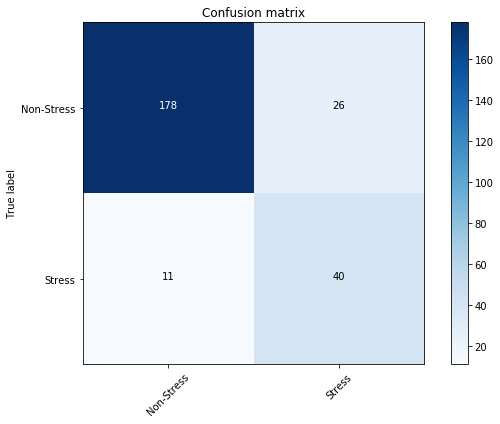

In [225]:
#By changing the labels and traning data labels 2:binary class and labels3:three classes
classes=["Non-Stress","Stress"]
result1 = np.array(labels2.iloc[:,0])
cnf = confusion_matrix(result1, result)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf, classes,
                      title='Confusion matrix')
plt.show()